In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 19:09:44.149138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 19:09:45.604284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 12500
end_idx = 13000
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(500, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(500, 96, 7)
(336000,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(500, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(500, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 19:09:54.708632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 19:09:58.042224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step
CPU time: 7683.279594111955 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

16/16 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.11243583 0.47257466 0.36268182 ... 0.74931454 0.92162843 0.50011115]
Fitness value of the best solution = 0.0007181065056155384


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

16/16 [==============================] - 0s 3ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


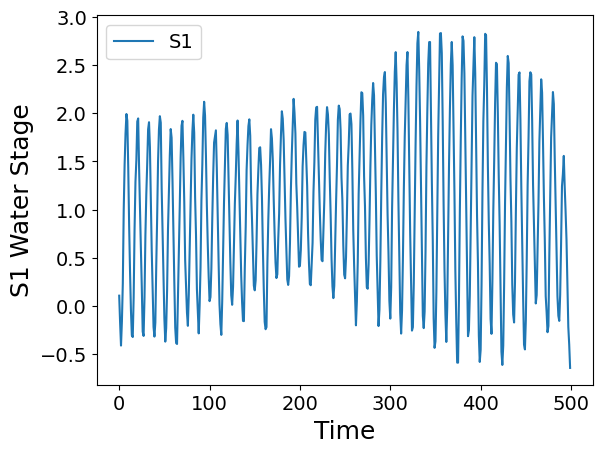

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low16.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.112436,0.472575,0.362682,0.599589,0.947336,0.356551,0.922196,0.794692,0.538933,0.859178,...,0.054651,0.131364,0.461097,0.884795,0.111513,0.330113,0.590526,0.606437,0.288791,0.449516
1,0.568422,0.777140,0.062163,0.722398,0.524127,0.019585,0.826862,0.217426,0.841896,0.218601,...,0.556130,0.283243,0.753195,0.702504,0.884433,0.453386,0.336288,0.926179,0.782990,0.532012
2,0.434785,0.407443,0.648122,0.883232,0.484261,0.221724,0.757826,0.124975,0.294444,0.712380,...,0.810309,0.216377,0.043854,0.449984,0.363792,0.345031,0.912573,0.938910,0.885386,0.452888
3,0.983203,0.766091,0.925385,0.377313,0.695382,0.981158,0.646308,0.098905,0.440567,0.822234,...,0.456923,0.771068,0.528158,0.766689,0.566360,0.698960,0.321420,0.858022,0.772485,0.740664
4,0.319866,0.047340,0.018478,0.279406,0.284699,0.761225,0.678958,0.391809,0.145803,0.129315,...,0.325347,0.847788,0.240304,0.484539,0.642302,0.024023,0.966753,0.982960,0.586809,0.955250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.509764,0.241568,0.989709,0.471111,0.380550,0.650374,0.155043,0.960998,0.609061,0.868494,...,0.843055,0.876526,0.002084,0.856151,0.235081,0.476871,0.347904,0.311363,0.139496,0.885551
496,0.295345,0.321565,0.865058,0.343642,0.292718,0.851515,0.204239,0.366614,0.338269,0.616006,...,0.388679,0.217271,0.311080,0.562478,0.990253,0.858503,0.187442,0.252991,0.495983,0.835832
497,0.434526,0.401048,0.849950,0.643918,0.385826,0.032282,0.623126,0.868659,0.290156,0.702817,...,0.513889,0.181633,0.469829,0.589687,0.818708,0.808074,0.980913,0.286158,0.366647,0.997326
498,0.390885,0.713762,0.689059,0.461524,0.058669,0.017413,0.312560,0.912728,0.579477,0.232138,...,0.350575,0.269219,0.558888,0.941985,0.283816,0.967704,0.850844,0.280022,0.265207,0.466887


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low16.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.107801,0.262375,0.233359,0.250895,-0.421031,-0.107824,-0.361663,-0.342639,-0.544099,-0.699156,...,1.780482,1.852582,1.401783,1.597976,1.509623,1.535740,0.976999,1.328535,1.087582,1.165765
1,-0.172198,0.112322,0.016988,-0.134314,-0.315363,-0.259332,-0.229468,-0.323934,-0.192496,-0.199665,...,1.402100,1.573522,1.002157,1.159425,1.192070,1.190055,0.641710,0.910765,0.847472,0.840196
2,-0.409811,-0.403357,-0.305479,-0.393801,-0.155658,0.046991,-0.120315,-0.064134,0.297415,0.458229,...,1.085645,1.127828,0.540501,0.676658,0.727723,0.709359,0.220795,0.267089,0.377164,0.402910
3,-0.159987,-0.080041,-0.076099,-0.197390,0.321035,0.429734,0.318552,0.283185,0.914447,0.912847,...,0.663780,0.713326,0.163373,0.310520,0.382517,0.353122,-0.012058,0.201278,0.198590,0.121328
4,0.234560,0.426550,0.233803,0.148625,1.021459,0.798505,1.025290,0.999645,1.418348,1.407083,...,0.203111,0.235471,-0.100080,-0.059753,0.063326,-0.015438,-0.138765,0.010379,-0.012378,-0.035632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.688204,0.878760,0.885390,0.821739,0.051865,0.051006,0.167402,0.164315,-0.298996,-0.052889,...,0.972579,1.148944,1.327053,1.229854,1.437950,1.546775,1.038452,1.293790,1.122670,1.203935
496,0.230999,0.459296,0.403108,0.326457,-0.218218,-0.258306,-0.050749,-0.175160,-0.585213,-0.298469,...,1.305118,1.391416,1.135934,1.347176,1.345699,1.375364,0.941804,1.054019,1.167641,1.188250
497,-0.215511,-0.330590,-0.019297,-0.250339,-0.481016,-0.531464,-0.337400,-0.521554,-0.629276,-0.549020,...,1.170009,1.314237,1.025476,1.053500,1.227694,1.180492,0.627621,0.772271,0.837492,0.779469
498,-0.398750,-0.511312,-0.226332,-0.433607,-0.611194,-0.323397,-0.569351,-0.647081,-0.254944,-0.145143,...,1.167446,1.212393,0.647978,0.758093,0.931304,0.811725,0.295224,0.631726,0.693388,0.571379


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 4389, areas: 866.5523282774084


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

16/16 [==============================] - 0s 3ms/step
time steps: 0, areas: 0
time steps: 8115, areas: 2201.3086090781308
